In [1]:
import json
from jupyterthemes import jtplot
import bz2
import re
from tqdm import tqdm
from scipy import sparse

In [2]:
tqdm.pandas()

C:\Users\psv52\Anaconda3\lib\site-packages\tqdm\_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# !jt -t monokai -f fira -fs 11 -nf ptsans -nfs 9 -N -kl -cursw 5 -cursc r -cellw 95% -T

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
jtplot.style()

Populating the interactive namespace from numpy and matplotlib


In [5]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:36, 2083.95it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [6]:
responses[90]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Возмещение страхового случая',
 'num_comments': 3,
 'bank_license': 'лицензия № 1623',
 'author': 'baleyil',
 'bank_name': 'ВТБ 24',
 'datetime': '2015-06-04 14:12:31',
 'text': 'Вчера - 03.06.15 - \xa0пришла в офис в  ВТБ-24 на Сходненской,\xa0  чтобы получить возмещение страхового случая по банку "Транспортный", в итоге мне сказали, что\xa0открыта запись только на субботу - 06.06.2015 и не ранее. В операционном зале пусто,\xa0клиентов и сотрудников банка\xa0нет.\xa0\xa0 Количество офисов по Москве у ВТБ 24 сопоставимо со Сбербанком, который выплачивает возмещение сразу же и даже без очереди и тем более без записи. Вопрос: зачем руководство банка ВТБ 24 подавало заявку на участие в возмещении страхового случая, если не может организовать работу?',
 'rating_grade': None}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

#### 1.  Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
df = pd.DataFrame(responses)

In [8]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [9]:
df['city'].value_counts(dropna=False).head(10)

г. Москва             55354
NaN                   15174
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
Name: city, dtype: int64

In [10]:
# удалим строки, в которых отсутствуют записи в поле город.
df.dropna(subset=['city'], inplace=True)

In [11]:
# также в некоторых записях присутствует латиница вместе с кириллицей
df[df['city'].str.contains('[a-z]', regex=True)].head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
12204,г. c.Коса,False,Не понятна ситуация по страховке,0,лицензия № 1481,NataOst,Сбербанк России,2015-02-24 21:03:00,"Добрый день, настоятельно прошу разобраться в ...",NaN
18330,г. Krasnoyarsk (Санкт-Петербург),False,Достали уже!,0,лицензия № 1460,jpnsk17,Восточный Экспресс Банк,2015-01-12 07:31:00,Господа изыскатели долгов. Вы когда кредиты ра...,NaN
22682,г. n/a (Москва),False,Мысли вслух,0,лицензия № 2673,beliyYAR,Тинькофф Банк,2014-12-18 12:22:00,Прошло уже 2.5 года от моей первой негативно-н...,5.0
32191,г. Bremen (Москва),False,Получение денежного перевода Вестерн Юнион,1,лицензия № 705,MaximL,СКБ-Банк,2014-10-03 12:02:00,Здравствуйте! 02.10. пытались получить денежны...,NaN
32668,"г. Booischot, Belgium (Москва)",False,С апреля не могу решить вопрос о реструктуриза...,0,лицензия № 2766,alex.avd2015,ОТП Банк,2014-09-29 14:20:00,"Я, Авдеев Александр Владимирович, 23.05.1971г,...",NaN


In [12]:
# или только названия городов на латинице
df[~df['city'].str.contains('[а-яА-Я]{2,}', regex=True)].head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
63548,г. Krasnoyarsk,False,Ужасное отношение,2,лицензия № 1623,sava124,ВТБ 24,2013-12-19 12:47:00,Всем привет. Решил взять кредит в Банке ВТБ 2...,1.0
63630,г. Indonesia,False,Блокировка карты заграницей,4,лицензия № 1961,testramb,Связной Банк,2013-12-19 23:44:00,По этому поводу большая переписка с вашим банк...,NaN
63685,г. Murmansk,False,Мой Банк,10,лицензия № 2939,vvo009,Мой Банк,2013-12-20 11:27:00,"Дамы и Господа, Может, мы уже перестанем этот ...",NaN
64145,г. Perm,False,Ограничения по исходящим платежам!,1,лицензия № 2241,realpower,Киви Банк,2013-12-16 01:18:00,Здравствуйте! Пользуюсь киви кошельком с 2013 ...,1.0
64299,г. Moscow,False,Продолжение истории со звонками коллекторов,1,лицензия № 3354,evgenykuk,Ренессанс Кредит,2013-12-16 10:36:00,"Была вот такая история . Вроде все хорошо, вс...",NaN


In [13]:
# чтобы не усложнять обработку данных оставим только кириллицу.

In [14]:
def cyrillic_only(raw):
    return ''.join(re.findall('[А-Яа-я-. ]', raw))

def remove_duplicates(raw):
    """
    Ф-я ставит точку после сокращения 'г.', если она отсутствует.
    Добавляет пробел после сокращения 'г.', если он отсутствует.
    Убирает дупликаты сокращений 'г.'.
    Меняет первую букву города на заглавную.
    """
    raw = re.sub('г ', 'г. ', raw)
    raw = re.sub('(г.)([А-Я])', r'г. \2', raw)
    raw = re.sub('г. г. ', 'г. ', raw)
    raw = re.sub(r'(г. )([А-Я]{2,})', lambda x: x.group(1) + x.group(2).lower().title(), raw)
    return re.sub(r'(г. )([а-я]{2,})', lambda x: x.group(1) + x.group(2).title(), raw)

In [15]:
df['city'] = df['city'].progress_apply(cyrillic_only).apply(remove_duplicates)

100%|██████████████████████████████████████████████████████████████████████| 138325/138325 [00:00<00:00, 274911.64it/s]


In [16]:
# после преобразований остались строчки без названий городов, удалим их
df[~df['city'].str.contains('[а-яА-Я]{2,}', regex=True)].head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
63548,г.,False,Ужасное отношение,2,лицензия № 1623,sava124,ВТБ 24,2013-12-19 12:47:00,Всем привет. Решил взять кредит в Банке ВТБ 2...,1.0
63630,г.,False,Блокировка карты заграницей,4,лицензия № 1961,testramb,Связной Банк,2013-12-19 23:44:00,По этому поводу большая переписка с вашим банк...,NaN
63685,г.,False,Мой Банк,10,лицензия № 2939,vvo009,Мой Банк,2013-12-20 11:27:00,"Дамы и Господа, Может, мы уже перестанем этот ...",NaN
64145,г.,False,Ограничения по исходящим платежам!,1,лицензия № 2241,realpower,Киви Банк,2013-12-16 01:18:00,Здравствуйте! Пользуюсь киви кошельком с 2013 ...,1.0
64299,г.,False,Продолжение истории со звонками коллекторов,1,лицензия № 3354,evgenykuk,Ренессанс Кредит,2013-12-16 10:36:00,"Была вот такая история . Вроде все хорошо, вс...",NaN


In [17]:
df.drop(df[~df['city'].str.contains('[а-яА-Я]{2,}', regex=True)].index, inplace=True)

In [18]:
# присутствует очень много городов написанных с ошибкой, либо с нестандартным указанием названия 
# (сокращенное, либо расширенное). Также удалим эти записи.
df['city'].value_counts()[df['city'].value_counts()==1].head(10)

г. Москваотделение Краснопресненское           1
г. Назрань Республика Ингушетия                1
г. Богородицк Тульская обл.                    1
г. Гдов                                        1
г. Мотыгино Красноярский край                  1
г. Москва Самара                               1
г. Петропавловск-Камчатский Камчатский край    1
г. Чепигинская                                 1
г. Раменкое                                    1
г. Мытищи-Москва-Новороссийск                  1
Name: city, dtype: int64

In [19]:
rare_cities = df['city'].value_counts()[df['city'].value_counts()==1].to_dict()

In [20]:
def del_rare_cities(raw):
    return raw in rare_cities.keys()

In [21]:
df.drop(df[df['city'].progress_apply(del_rare_cities)].index, inplace=True)

100%|█████████████████████████████████████████████████████████████████████| 138151/138151 [00:00<00:00, 1214769.10it/s]


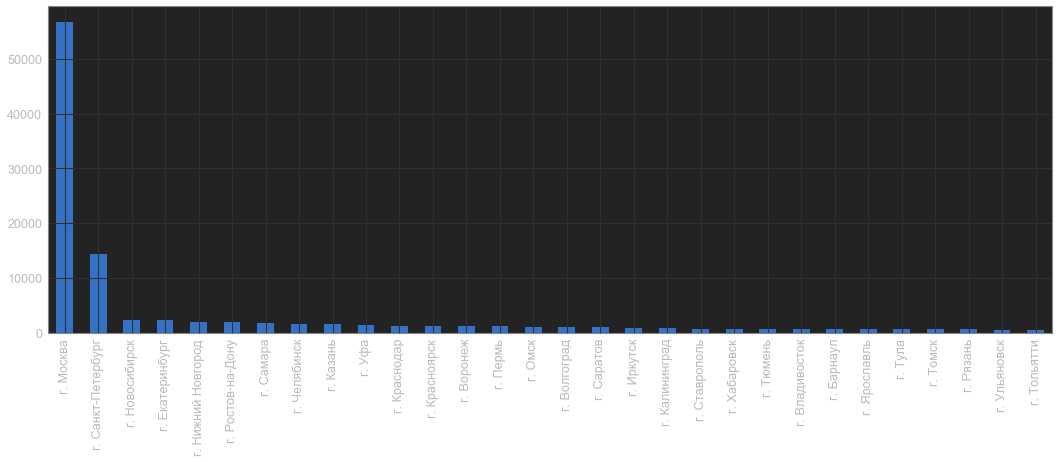

In [22]:
# построим распределение количества отзывов по городам.
plt.figure(figsize=(18, 6))
ax = df['city'].value_counts()[:30].plot(kind='bar')

In [23]:
# Количество отзывов по городам:
df['city'].value_counts().head(10)

г. Москва             56782
г. Санкт-Петербург    14358
г. Новосибирск         2384
г. Екатеринбург        2376
г. Нижний Новгород     1979
г. Ростов-на-Дону      1905
г. Самара              1785
г. Челябинск           1541
г. Казань              1516
г. Уфа                 1322
Name: city, dtype: int64

In [24]:
# количество отзывов по банкам.
df['bank_name'].value_counts(dropna=False).head(10)

Сбербанк России              24472
Альфа-Банк                    8905
ВТБ 24                        7169
Хоум Кредит Банк              7145
Русский Стандарт              7073
Тинькофф Банк                 5169
Национальный Банк «Траст»     4382
Связной Банк                  3699
Ренессанс Кредит              3326
ОТП Банк                      2962
Name: bank_name, dtype: int64

In [25]:
# редкие банки.
rare_banks = df['bank_name'].value_counts()[df['bank_name'].value_counts()==1].to_dict()

In [26]:
def del_rare_banks(raw):
    return raw in rare_banks.keys()

In [27]:
df.drop(df[df['bank_name'].progress_apply(del_rare_banks)].index, inplace=True)

100%|█████████████████████████████████████████████████████████████████████| 134872/134872 [00:00<00:00, 1127267.05it/s]


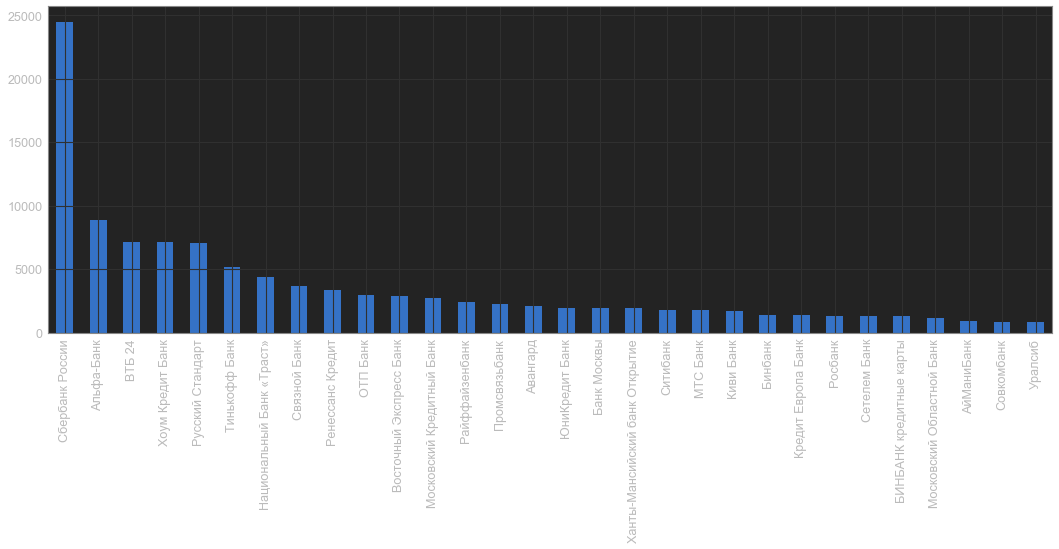

In [28]:
# построим распределение количества отзывов по банкам.
plt.figure(figsize=(18, 6))
ax = df['bank_name'].value_counts()[:30].plot(kind='bar')

In [29]:
# Количество отзывов по банкам:
df['bank_name'].value_counts().head(10)

Сбербанк России              24472
Альфа-Банк                    8905
ВТБ 24                        7169
Хоум Кредит Банк              7145
Русский Стандарт              7073
Тинькофф Банк                 5169
Национальный Банк «Траст»     4382
Связной Банк                  3699
Ренессанс Кредит              3326
ОТП Банк                      2962
Name: bank_name, dtype: int64

#### 2. Постройте гистограмы текстов в символах и в словах

In [30]:
regex = re.compile('[а-яё]{3,}')

def words_only(raw, regex=regex):
    try:
        return ' '.join(regex.findall(raw))
    except:
        return ''

In [31]:
df['text'] = df['text'].str.lower()

In [32]:
texts = df['text'].progress_apply(words_only)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:07<00:00, 18200.16it/s]


In [33]:
symbol_length = texts.str.len()

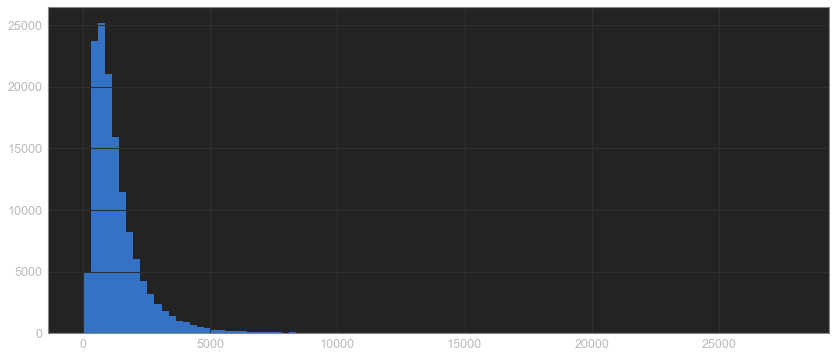

In [34]:
ax = symbol_length.hist(bins=100, figsize=(14,6))

In [35]:
words_length = texts.str.split(' ').str.len()

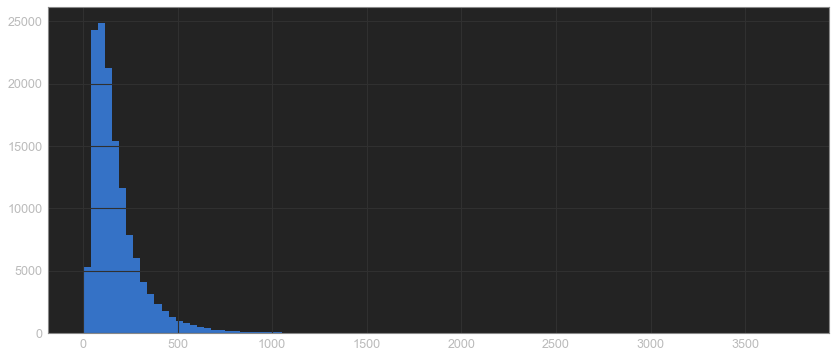

In [36]:
ax = words_length.hist(bins=100, figsize=(14,6))

3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

In [37]:
texts = texts.str.split()

In [38]:
texts.head()

0    [добрый, день, являюсь, клиентом, банка, поруч...
1    [доброго, дня, являюсь, держателем, зарплатной...
2    [здравствуйте, дублирую, свое, заявление, можа...
3    [добрый, день, открыл, расчетный, счет, сберба...
4    [взяла, кредит, вашем, банке, заявленная, мною...
Name: text, dtype: object

In [39]:
from collections import Counter

In [40]:
cnt_words = Counter()
for text in tqdm(texts):
    cnt_words.update(text)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:03<00:00, 35512.62it/s]


In [41]:
# 10 самых частых слов
cnt_words.most_common(20)

[('что', 569800),
 ('мне', 287919),
 ('банка', 249654),
 ('банк', 193655),
 ('как', 181998),
 ('меня', 166987),
 ('это', 161255),
 ('все', 147597),
 ('так', 130910),
 ('деньги', 116672),
 ('для', 104501),
 ('было', 104172),
 ('уже', 96127),
 ('карту', 95669),
 ('через', 93430),
 ('карты', 93303),
 ('при', 82791),
 ('нет', 78747),
 ('только', 77652),
 ('еще', 73728)]

In [42]:
from nltk.corpus import stopwords

In [43]:
my_stopwords = set(stopwords.words('russian') + ['это', 'что', 'мне', 'как', 'меня', 'все',
                                                 'так', 'для', 'было', 'уже', 'через', 'при', 'только', 
                                                 'еще', 'наш', 'также', 'добрый', 'день', 'здравствуйте'])

In [44]:
def del_stop_words(text, stop_words=my_stopwords):
    try:
        return [word for word in text if word not in stop_words]
    except:
        return []

In [45]:
texts_cleaned = texts.progress_apply(del_stop_words)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:02<00:00, 50448.88it/s]


In [46]:
cnt_words_cleaned = Counter()
for text in tqdm(texts_cleaned):
    cnt_words_cleaned.update(text)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:03<00:00, 44423.39it/s]


In [47]:
# 10 самых частых слов без стоп-слов
cnt_words_cleaned.most_common(10)

[('банка', 249654),
 ('банк', 193655),
 ('деньги', 116672),
 ('карту', 95669),
 ('карты', 93303),
 ('кредит', 70709),
 ('заявление', 64278),
 ('банке', 63928),
 ('отделение', 59425),
 ('время', 58177)]

In [48]:
from pymorphy2 import MorphAnalyzer

In [49]:
pm2 = MorphAnalyzer()
def lemmatize(text, lemmatizer=pm2):
    try:
        return [lemmatizer.parse(word)[0].normal_form for word in text] 
    except:
        return []

In [50]:
lemms = texts_cleaned.progress_apply(lemmatize)

100%|██████████████████████████████████████████████████████████████████████████| 134751/134751 [36:12<00:00, 62.04it/s]


In [51]:
lemms.head(10)

0    [являться, клиент, банка, поручитель, кредитны...
1    [добрый, день, являться, держатель, зарплатный...
2    [дублировать, свой, заявление, можайский, я, м...
3    [открыть, расчётный, счёт, сбербанк, лицо, оди...
4    [взять, кредит, ваш, банка, заявить, я, сумма,...
5    [многие, вкладчик, открыть, рубль, счастливый,...
6    [подать, заявление, получение, уэк, отделение,...
7    [крайне, удивлённый, новость, май, унификация,...
8    [сотрудник, банка, восточный, систематически, ...
9    [являться, заёмщик, банка, втб, год, назад, вз...
Name: text, dtype: object

In [52]:
cnt_lemm = Counter()

for text in tqdm(lemms):
    cnt_lemm.update(text)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:02<00:00, 51142.98it/s]


In [53]:
cnt_lemm.most_common(10)

[('банка', 359155),
 ('карта', 304249),
 ('банк', 241091),
 ('деньга', 159678),
 ('мой', 147282),
 ('кредит', 137109),
 ('который', 133799),
 ('отделение', 127341),
 ('счёт', 126447),
 ('сотрудник', 122409)]

Как видно лемматизация немного подвела и саммой распространенной леммой стала банка. Т.к. едва ли в данном датасете могут упоминаться банки (в смысл тары) преобразуем данные леммы в банки (в смысле финансовых учреждений). 

In [54]:
def jars_to_banks(text):
    try:
        return [word if word != 'банка' else 'банк' for word in text]
    except:
        return []

In [55]:
lemms = lemms.progress_apply(jars_to_banks)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:02<00:00, 54178.73it/s]


In [56]:
cnt_lemm = Counter()

for text in tqdm(lemms):
    cnt_lemm.update(text)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:02<00:00, 57825.35it/s]


In [57]:
cnt_lemm.most_common(10)

[('банк', 600246),
 ('карта', 304249),
 ('деньга', 159678),
 ('мой', 147282),
 ('кредит', 137109),
 ('который', 133799),
 ('отделение', 127341),
 ('счёт', 126447),
 ('сотрудник', 122409),
 ('клиент', 121453)]

In [58]:
lemms.apply(len).sum()

19104032

In [59]:
# попробуем еще раз удалить стоп-слова
lemms = lemms.progress_apply(del_stop_words)

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:02<00:00, 48726.43it/s]


In [60]:
# количество слов немного сократилось
lemms.apply(len).sum()

18316731

In [61]:
most_common_nouns = {}
cnt = 0
for word, num in cnt_lemm.most_common():
    if 'NOUN' in pm2.parse(word)[0].tag:
        cnt += 1
        most_common_nouns[word] = num
    else:
        continue
    if cnt == 10:
        break

In [62]:
# 10 самых частых существительных
most_common_nouns

{'банк': 600246,
 'карта': 304249,
 'деньга': 159678,
 'кредит': 137109,
 'отделение': 127341,
 'счёт': 126447,
 'сотрудник': 122409,
 'клиент': 121453,
 'сумма': 100409,
 'заявление': 95520}

4. Постройте кривые Ципфа и Хипса

Закон Ципфа

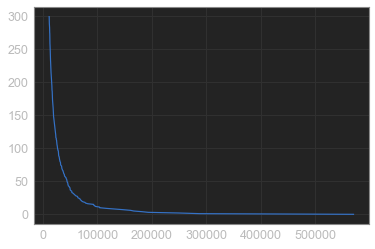

In [63]:
freqs = list(cnt_words.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Закон Хипса

In [64]:
n_tokens = np.cumsum(texts.apply(len))

In [65]:
words_set = set()
n_types = []
for text in tqdm(texts):
    words_set.update(set(text))
    n_types.append(len(words_set))

100%|███████████████████████████████████████████████████████████████████████| 134751/134751 [00:02<00:00, 55748.15it/s]


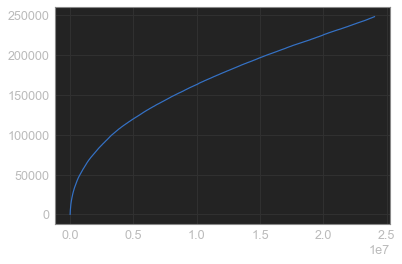

In [66]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [67]:
print(f'''слово "сотрудник" встречается \t{cnt_lemm['сотрудник']} раз\n
слово "клиент" встречается \t{cnt_lemm['клиент']} раз''')

слово "сотрудник" встречается 	122409 раз

слово "клиент" встречается 	121453 раз


Слово "сотрудник" встречается чаще слова "клиент"

In [68]:
print(f'''слово "мошенничество" встречается \t{cnt_lemm['мошенничество']} раз''')

слово "мошенничество" встречается 	3026 раз


In [69]:
print(f'''слово "доверие" встречается \t{cnt_lemm['доверие']} раз''')

слово "доверие" встречается 	1871 раз


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [70]:
df['rating_grade'].value_counts(dropna=False)

NaN    61873
1.0    38830
2.0    12959
5.0    10254
3.0     7351
4.0     3484
Name: rating_grade, dtype: int64

In [71]:
df_1 = df[df['rating_grade']==1].sample(10000)
df_5 = df[df['rating_grade']==5].sample(10000)

In [81]:
df_1 = df_1.join(lemms, rsuffix='_lemms')
df_5 = df_5.join(lemms, rsuffix='_lemms')

In [ ]:
df_1.drop(['text', 'bank_license', 'datetime'], axis=1, inplace=True)
df_5.drop(['text', 'bank_license', 'datetime'], axis=1, inplace=True)

In [82]:
df_1.head()

,city,rating_not_checked,title,num_comments,author,bank_name,rating_grade,text,text_lemms
22381,г. Ярославль,False,Телефонный терроризм от Росбанка,1,Зараза,Росбанк,1.0,"[время, сутки, ежедневно, звонить, номер, ваш,...","[время, сутки, ежедневно, звонить, номер, ваш,..."
62277,г. Москва,False,"""Геморройный"" банк!",1,Alex020969,Ренессанс Кредит,1.0,"[являться, клиент, банк, протяжение, год, отде...","[являться, клиент, банк, протяжение, год, отде..."
74339,г. Челябинск,False,Длинная история!,0,alex777888,Сбербанк России,1.0,"[начаться, банкомат, вернуть, карта, майский, ...","[начаться, банкомат, вернуть, карта, майский, ..."
54853,г. Москва,False,"Безобразное отношение в офисе ""Вешняки""",1,босяк-68,Национальный Банк «Траст»,1.0,"[сегодня, приехать, банк, примерно, дверь, сид...","[сегодня, приехать, банк, примерно, дверь, сид..."
26070,г. Кемерово,False,Проблема с подключением СМС оповещения,1,draikus089,ВТБ 24,1.0,"[оформить, карта, октябрь, прошлое, год, выдач...","[оформить, карта, октябрь, прошлое, год, выдач..."


In [83]:
df_1_tokens = [' '.join([word for word in text]) for text in df_1['text_lemms']]
df_5_tokens = [' '.join([word for word in text]) for text in df_5['text_lemms']]

In [84]:
df_1_tokens = ' '.join(sent for sent in df_1_tokens)
df_5_tokens = ' '.join(sent for sent in df_5_tokens)

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [86]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), lowercase=False)

In [87]:
tfidf_matrix =  tfidf.fit_transform([df_1_tokens, df_5_tokens])

In [88]:
tfidf_matrix.shape

(2, 1192625)

In [89]:
feature_names = tfidf.get_feature_names()

In [90]:
dense = tfidf_matrix.toarray()

In [91]:
rankings = pd.DataFrame(data=dense.T, index=feature_names, columns=['rate_1', 'rate_5'])

In [92]:
rankings.head()

,rate_1,rate_5
ааа,0.000036,0.000027
ааа дать,0.000017,0.000000
ааа оператор,0.000017,0.000000
ааа отличный,0.000000,0.000019
ааа пятёрка,0.000000,0.000019


In [93]:
rankings['bigram'] = rankings.index.str.contains(' ').astype(int)

In [94]:
# Из-за того, что для tf-idf использовалось всего лишь 2 документа (для оценок 1 и 5), то idf составляющая практически не 
# играет роли. Отнормируем значения tf-idf для каждой из оценок, вычтя соответствуюещее значение tf-idf противоположной оценки. 
rankings['rate_1_normed'] = rankings['rate_1'] - rankings['rate_5']
rankings['rate_5_normed'] = rankings['rate_5'] - rankings['rate_1']

In [95]:
# ключевые слова для оценки 1
rankings.loc[rankings['bigram']==0, 'rate_1_normed'].sort_values(ascending=False).head(10)

заявление    0.084357
деньга       0.065733
рубль        0.059946
карта        0.057293
ответ        0.053006
номер        0.051943
сказать      0.049306
звонить      0.046449
сумма        0.046311
сбербанк     0.046019
Name: rate_1_normed, dtype: float64

In [96]:
# ключевые слова для оценки 5
rankings.loc[rankings['bigram']==0, 'rate_5_normed'].sort_values(ascending=False).head(10)

очень           0.112745
банк            0.089728
вклад           0.068814
спасибо         0.061779
быстро          0.050817
обслуживание    0.042041
работа          0.041706
хороший         0.036646
весь            0.033725
приятно         0.033547
Name: rate_5_normed, dtype: float64

In [97]:
# ключевые биграммы для оценки 1
rankings.loc[rankings['bigram']==1, 'rate_1_normed'].sort_values(ascending=False).head(10)

денежный средство     0.017743
написать заявление    0.017410
горячий линия         0.015860
отделение банк        0.011531
сотрудник банк        0.009939
сей пора              0.009257
ваш банк              0.008010
писать заявление      0.007893
отделение сбербанк    0.007128
сумма рубль           0.006860
Name: rate_1_normed, dtype: float64

In [98]:
# ключевые биграммы для оценки 5
rankings.loc[rankings['bigram']==1, 'rate_5_normed'].sort_values(ascending=False).head(10)

интернет банк             0.021121
хотеть выразить           0.009550
очень удобно              0.008388
очень довольный           0.008376
очень быстро              0.008305
клиент банк               0.008300
выразить благодарность    0.008002
банк очень                0.007644
большой спасибо           0.007363
огромный спасибо          0.006987
Name: rate_5_normed, dtype: float64

Как видно биграммы лучше показывают различие оценок 1 и 5

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [99]:
df = df.join(lemms, rsuffix='_lemms')

In [100]:
lemms.head()

0    [являться, клиент, банк, поручитель, кредитный...
1    [являться, держатель, зарплатный, карта, выдат...
2    [дублировать, свой, заявление, можайский, дебе...
3    [открыть, расчётный, счёт, сбербанк, лицо, дог...
4    [взять, кредит, ваш, банк, заявить, сумма, руб...
Name: text, dtype: object

In [101]:
from gensim.corpora import *

C:\Users\psv52\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [102]:
dictionary = Dictionary(lemms)
corpus = [dictionary.doc2bow(text) for text in lemms]

In [103]:
from gensim.models import  *
# from gensim import similarities

In [104]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [105]:
from gensim.models.coherencemodel import CoherenceModel

In [106]:
 def optimal_model(corpus_tfidf, dictionary, lemms, topic_model):
    """
    Функция подбирает оптимальное количество топиков по критерию когерентности.
    Возвращает список моделей с различным количеством топиков и список соответствующих
    этим моделям значений когерентности.
    """
    models = []
    coherence_vals = []
    for n in tqdm(range(3, 22, 2)):
        if topic_model == 'lsa':
        # generate LSA model
            model = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n)  # train model
        elif topic_model == 'lda':
        # generate LDA model
            model = ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)
        else:
            raise ValueError("Unknown topic model was passed")
        coherencemodel = CoherenceModel(model=model, texts=lemms, dictionary=dictionary, coherence='c_v')
        coherence_vals.append(coherencemodel.get_coherence())
        models.append(model)
    return models, coherence_vals 

In [107]:
# создадим различные поднаборы документов, отобранные для разных оценок, банков и городов.
topics_1 = {'rating_grade': df['rating_grade'].value_counts().head(5).index.tolist()}
topics_2 = {'bank_name': df['bank_name'].value_counts().head(5).index.tolist()}
topics_3 = {'city': df['city'].value_counts().head(5).index.tolist()}

In [108]:
def get_lemms_for_topic(topics):
    """
    Функция отибирает леммы для заданной коллекции топиков.
    Под каждый топик отбирается 1000 документов.
    """
    indexes = []
    col = list(topics.keys())[0]
    topics = topics[col]
    for topic in topics:
        indexes += df[df[col]==topic].sample(min(2000, df[col].value_counts()[topic])).index.tolist()
    return lemms[indexes]

In [109]:
topics_1_lemms = get_lemms_for_topic(topics_1)
topics_2_lemms = get_lemms_for_topic(topics_2)
topics_3_lemms = get_lemms_for_topic(topics_3)

In [110]:
def get_tfidf_corpus(lemms):
    dictionary = Dictionary(lemms)
    corpus = [dictionary.doc2bow(text) for text in lemms]
    tfidf = TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf, dictionary, lemms

1. Латентно-семантический анализ [LSA]

In [111]:
lsa_model_1, lsa_coherence_vals_1 = optimal_model(*get_tfidf_corpus(topics_1_lemms), 'lsa')
lsa_model_2, lsa_coherence_vals_2 = optimal_model(*get_tfidf_corpus(topics_2_lemms), 'lsa')
lsa_model_3, lsa_coherence_vals_3 = optimal_model(*get_tfidf_corpus(topics_3_lemms), 'lsa')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.85s/it]


In [112]:
# словарь соответствий количества топиков индексу модели в списке models
n_to_ind = dict(zip(range(3, 22, 2), range(0, 9)))

In [113]:
def plot_coherence(lsa_coherence_vals):
    """
    Функция для печати графика когерентности.
    """
    ax = plt.plot(lsa_coherence_vals)
    plt.xlabel('number of topics')
    plt.ylabel('coherence')
    x = plt.xticks(range(0, 9), range(3, 22, 2))

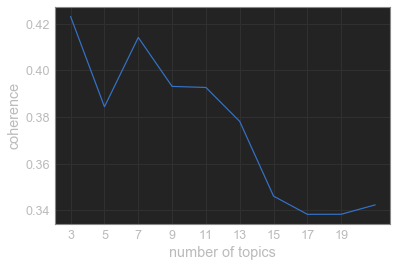

In [114]:
plot_coherence(lsa_coherence_vals_1)

In [115]:
lsa_model_1[n_to_ind[3]].show_topics()

[(0,
  '0.193*"карта" + 0.134*"кредит" + 0.130*"вклад" + 0.110*"деньга" + 0.108*"банкомат" + 0.104*"счёт" + 0.104*"заявление" + 0.100*"отделение" + 0.089*"кредитный" + 0.089*"рубль"'),
 (1,
  '0.571*"вклад" + -0.162*"кредит" + 0.160*"очередь" + -0.153*"заявление" + 0.139*"открыть" + -0.119*"платёж" + -0.107*"карта" + -0.106*"банкомат" + -0.099*"задолженность" + 0.099*"депозит"'),
 (2,
  '-0.423*"кредит" + 0.365*"банкомат" + 0.235*"карта" + -0.185*"страховка" + -0.158*"договор" + -0.151*"погашение" + -0.150*"документ" + 0.149*"деньга" + -0.133*"заявка" + 0.124*"сбербанк"')]

В целом, получились очень похожие темы с практически одинаковым набором слов.

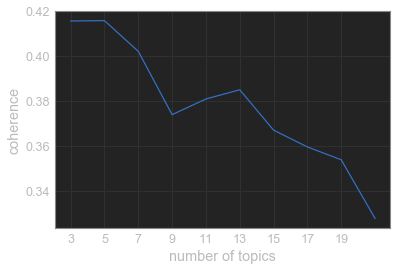

In [116]:
plot_coherence(lsa_coherence_vals_2)

In [117]:
lsa_model_2[n_to_ind[5]].show_topics()

[(0,
  '0.185*"карта" + 0.136*"кредит" + 0.124*"банкомат" + 0.123*"деньга" + 0.114*"заявление" + 0.114*"счёт" + 0.103*"рубль" + 0.102*"сбербанк" + 0.098*"сумма" + 0.098*"отделение"'),
 (1,
  '0.394*"банкомат" + -0.298*"кредит" + -0.202*"страховка" + 0.201*"деньга" + 0.173*"карта" + 0.153*"сбербанк" + -0.146*"договор" + -0.138*"звонок" + 0.138*"операция" + -0.129*"страхование"'),
 (2,
  '-0.381*"вклад" + 0.251*"номер" + 0.221*"звонок" + 0.183*"банкомат" + -0.180*"страховка" + 0.143*"телефон" + 0.135*"звонить" + 0.126*"претензия" + 0.124*"ваш" + -0.117*"очередь"'),
 (3,
  '0.295*"страховка" + 0.232*"кредит" + -0.225*"вклад" + 0.215*"банкомат" + 0.187*"рубль" + 0.186*"страхование" + 0.181*"сумма" + -0.171*"номер" + 0.152*"погашение" + 0.140*"платёж"'),
 (4,
  '0.438*"банкомат" + -0.241*"карта" + -0.208*"сбербанк" + 0.166*"купюра" + -0.139*"списание" + -0.135*"средство" + 0.124*"очередь" + 0.112*"заявка" + 0.111*"вклад" + -0.111*"перевод"')]

Такая же ситуация.

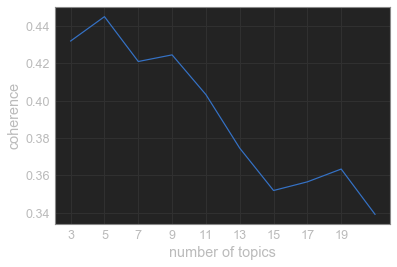

In [118]:
plot_coherence(lsa_coherence_vals_3)

In [119]:
lsa_model_3[n_to_ind[5]].show_topics()

[(0,
  '0.194*"карта" + 0.139*"кредит" + 0.119*"деньга" + 0.115*"банкомат" + 0.113*"заявление" + 0.112*"счёт" + 0.103*"рубль" + 0.103*"отделение" + 0.101*"сумма" + 0.097*"платёж"'),
 (1,
  '0.371*"банкомат" + -0.366*"кредит" + -0.266*"страховка" + 0.215*"карта" + -0.163*"договор" + 0.160*"деньга" + 0.141*"операция" + -0.139*"страхование" + 0.135*"сбербанк" + -0.113*"погашение"'),
 (2,
  '0.624*"вклад" + -0.196*"банкомат" + 0.140*"очередь" + -0.136*"платёж" + 0.134*"открыть" + -0.116*"заявление" + 0.111*"офис" + -0.109*"претензия" + -0.105*"рубль" + -0.105*"задолженность"'),
 (3,
  '-0.262*"вклад" + 0.246*"номер" + -0.232*"страховка" + -0.212*"банкомат" + 0.192*"звонок" + -0.189*"сумма" + -0.187*"рубль" + 0.157*"телефон" + 0.143*"звонить" + -0.141*"процент"'),
 (4,
  '-0.365*"банкомат" + -0.303*"страховка" + -0.228*"заявка" + 0.227*"вклад" + 0.198*"платёж" + 0.171*"задолженность" + 0.120*"счёт" + -0.117*"кредит" + -0.115*"страхование" + 0.114*"комиссия"')]

Как видно, модель lsa не позволила выделить интерпретируемые топики.

In [120]:
lda_model_1, lda_coherence_vals_1 = optimal_model(*get_tfidf_corpus(topics_1_lemms), 'lda')
lda_model_2, lda_coherence_vals_2 = optimal_model(*get_tfidf_corpus(topics_2_lemms), 'lda')
lda_model_3, lda_coherence_vals_3 = optimal_model(*get_tfidf_corpus(topics_3_lemms), 'lda')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:58<00:00, 42.84s/it]


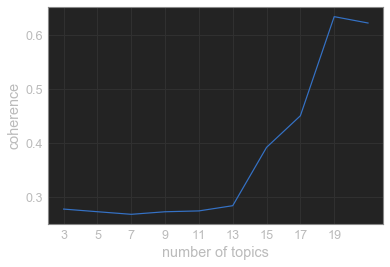

In [121]:
plot_coherence(lda_coherence_vals_1)

In [122]:
lda_model_1[n_to_ind[19]].show_topics()

[(18,
  '0.001*"оборудовать" + 0.001*"тыща" + 0.001*"опрос" + 0.001*"поощрение" + 0.001*"азовский" + 0.001*"электросталь" + 0.001*"людмила" + 0.001*"карта" + 0.001*"безболезненно" + 0.001*"бумажник"'),
 (12,
  '0.002*"отрадный" + 0.001*"плодотворный" + 0.001*"тесный" + 0.001*"весомый" + 0.001*"отклик" + 0.001*"годиться" + 0.001*"карта" + 0.001*"пускай" + 0.001*"вклад" + 0.001*"банкомат"'),
 (7,
  '0.002*"итб" + 0.002*"токен" + 0.001*"сбрф" + 0.001*"пиф" + 0.001*"строгий" + 0.001*"оцениваться" + 0.001*"закладка" + 0.001*"куратор" + 0.001*"понервничать" + 0.001*"возрождение"'),
 (14,
  '0.003*"тьфу" + 0.001*"дебетовка" + 0.001*"немаловажный" + 0.001*"сравнительно" + 0.001*"случается" + 0.001*"айманибанк" + 0.001*"шампанский" + 0.001*"классика" + 0.001*"бутырский" + 0.001*"вытягивать"'),
 (3,
  '0.001*"ломаться" + 0.001*"высота" + 0.001*"пресня" + 0.001*"крыльцо" + 0.001*"старт" + 0.001*"тестирование" + 0.001*"розница" + 0.001*"вна" + 0.001*"учредитель" + 0.001*"приоритетный"'),
 (17,
  '

В случае LDA получились более разнообразные и осмысленные темы. Например 13-я тема явно связана с положительными оценками и благодарностями банкам, в то время как 14-я, наоборот, с отрицательными отзывами.

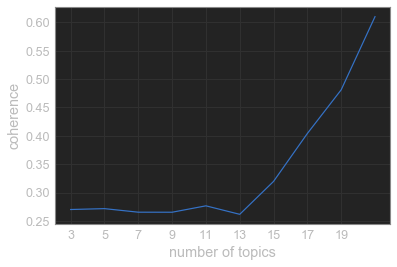

In [123]:
plot_coherence(lda_coherence_vals_2)

In [124]:
lda_model_2[n_to_ind[19]].show_topics(19)

[(0,
  '0.005*"хоум" + 0.005*"звонок" + 0.004*"карман" + 0.004*"номер" + 0.004*"задолженность" + 0.003*"ваш" + 0.003*"кредит" + 0.003*"долг" + 0.003*"телефон" + 0.003*"поступать"'),
 (1,
  '0.003*"ноутбук" + 0.003*"сокол" + 0.002*"разглашать" + 0.002*"помощник" + 0.002*"пометка" + 0.001*"валентин" + 0.001*"наводить" + 0.001*"фин" + 0.001*"сбербанк" + 0.001*"агенство"'),
 (2,
  '0.002*"беляево" + 0.001*"юникредит" + 0.001*"сбербанк" + 0.001*"опаздывать" + 0.001*"ресепшено" + 0.001*"оптимальный" + 0.001*"карта" + 0.001*"придерживаться" + 0.001*"номер" + 0.001*"кредит"'),
 (3,
  '0.002*"терроризировать" + 0.002*"ухудшение" + 0.002*"пропуск" + 0.002*"наука" + 0.001*"бешеный" + 0.001*"сбербанк" + 0.001*"марина" + 0.001*"валовый" + 0.001*"вокзал" + 0.001*"карта"'),
 (4,
  '0.005*"бюро" + 0.003*"евросеть" + 0.002*"планшет" + 0.001*"юлия" + 0.001*"сбербанк" + 0.001*"тёща" + 0.001*"соколов" + 0.001*"лоток" + 0.001*"регулятор" + 0.001*"карта"'),
 (5,
  '0.002*"мирный" + 0.001*"сбербанк" + 0.001*

В основном в темах фигурирует сбербанк, например, 7-я тема явно связана с негативом в адрес этого банка.

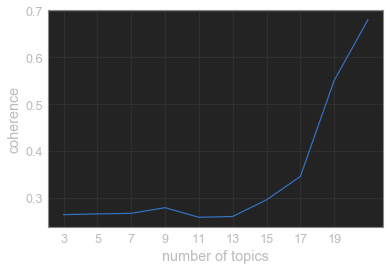

In [125]:
plot_coherence(lda_coherence_vals_3)

In [126]:
lda_model_3[n_to_ind[19]].show_topics()

[(10,
  '0.002*"монета" + 0.002*"лукойл" + 0.002*"хранитель" + 0.001*"азс" + 0.001*"локо" + 0.001*"кредит" + 0.001*"карта" + 0.001*"крым" + 0.001*"кусок" + 0.001*"убежать"'),
 (9,
  '0.001*"судостроительный" + 0.001*"номерок" + 0.001*"ян" + 0.001*"нехороший" + 0.001*"сверхлимитный" + 0.001*"кредит" + 0.001*"карта" + 0.001*"зав" + 0.001*"бин" + 0.001*"помощник"'),
 (8,
  '0.002*"бик" + 0.001*"счётчик" + 0.001*"валентин" + 0.001*"щас" + 0.001*"юнистрим" + 0.001*"кредит" + 0.001*"карта" + 0.001*"неудачно" + 0.001*"суточный" + 0.001*"павло"'),
 (6,
  '0.003*"маня" + 0.003*"джия" + 0.002*"ржд" + 0.001*"кэшбек" + 0.001*"тёща" + 0.001*"транскредит" + 0.001*"транскредитбанк" + 0.001*"выбить" + 0.001*"отправление" + 0.001*"типо"'),
 (0,
  '0.001*"кузнецов" + 0.001*"материнский" + 0.001*"алименты" + 0.001*"долговой" + 0.001*"применение" + 0.001*"ненадлежащий" + 0.001*"нестабильный" + 0.001*"квиток" + 0.001*"кредит" + 0.001*"карта"'),
 (13,
  '0.002*"моментум" + 0.001*"служащий" + 0.001*"сохранит

В данном случае получился сплошной негатив, так же в темах появились города, которые использовались для отбора документов.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [127]:
X = pd.concat([df_1['text_lemms'], df_5['text_lemms']])
y = pd.concat([df_1['rating_grade'], df_5['rating_grade']])

In [128]:
X = X.apply(lambda lst: ' '.join(word for word in lst))

In [129]:
from sklearn.model_selection import train_test_split

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.decomposition import LatentDirichletAllocation

In [156]:
models_result = {'Model': [], 'Accuracy': [], 'F1_score': []}

Попробуем модель MultinomialNB с и без LDA

In [157]:
text_clf_mnb = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('lda', LatentDirichletAllocation()),
        ('clf', MultinomialNB()),
    ])

gs_mnb_params = [
        {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'lda__n_components': (10, 50, 100),
        'clf__alpha': (1, 1e-1, 1e-2)
        },
        {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'lda': [None],
        'clf__alpha': (1, 1e-1, 1e-2)
        }
]

scoring = {'F1': 'f1', 'Accuracy': make_scorer(accuracy_score)}

In [158]:
gs_clf_mnb = GridSearchCV(text_clf_mnb, gs_mnb_params, cv=3, n_jobs=-1, verbose=5, scoring=scoring, refit='Accuracy')

In [159]:
gs_clf_mnb = gs_clf_mnb.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 44.5min finished


In [160]:
pd.DataFrame(gs_clf_mnb.cv_results_).iloc[:,4:].sort_values('mean_test_Accuracy', ascending=False).head().T

,47,41,45,43,37
param_clf__alpha,0.01,0.1,0.01,0.1,1
param_lda__n_components,NaN,NaN,NaN,NaN,NaN
param_tfidf__use_idf,False,True,True,False,True
param_vect__ngram_range,"(1, 2)","(1, 2)","(1, 2)","(1, 2)","(1, 2)"
param_lda,None,None,None,None,None
params,"{'clf__alpha': 0.01, 'lda': None, 'tfidf__use_...","{'clf__alpha': 0.1, 'lda': None, 'tfidf__use_i...","{'clf__alpha': 0.01, 'lda': None, 'tfidf__use_...","{'clf__alpha': 0.1, 'lda': None, 'tfidf__use_i...","{'clf__alpha': 1, 'lda': None, 'tfidf__use_idf..."
split0_test_F1,0.932312,0.931826,0.929249,0.927403,0.923328
split1_test_F1,0.925716,0.925379,0.923862,0.921266,0.91881
split2_test_F1,0.929799,0.93053,0.926669,0.927915,0.927621
mean_test_F1,0.929276,0.929245,0.926593,0.925528,0.923253


Без LDA результаты получились лучше, возможно было взято недостаточное кол-во топиков. Добавление биграмм дало лучший результат.

In [161]:
y_test_pred = gs_clf_mnb.predict(X_test)

In [162]:
import seaborn
from sklearn.metrics import confusion_matrix, classification_report

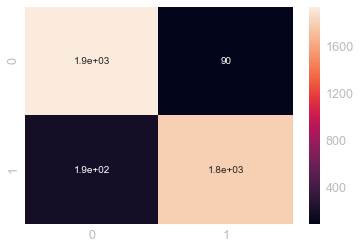

In [163]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)

In [164]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.91      0.96      0.93      2019
         5.0       0.95      0.90      0.93      1981

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



In [165]:
models_result['Model'] += ['MultinomialNB']
models_result['Accuracy'] += [accuracy_score(y_test, y_test_pred)]
models_result['F1_score'] += [f1_score(y_test, y_test_pred)]

Попробуем RandomForestClassifier с LDA, LSA и без них.

In [166]:
text_clf_rfc = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('svd', TruncatedSVD()),
        ('lda', LatentDirichletAllocation()),
        ('clf', RandomForestClassifier(n_estimators=100)),
    ])

gs_rfc_params = [
        {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'svd__n_components': [10, 50, 100],
        'lda': [None],
        },
        {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'svd': [None],
        'lda__n_components': [10, 50, 100],
        },
        {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'svd': [None],
        'lda': [None],
        },
    ]

scoring = {'F1': 'f1', 'Accuracy': make_scorer(accuracy_score)}

In [167]:
gs_clf_rfc = GridSearchCV(text_clf_rfc, gs_rfc_params, cv=3, n_jobs=-1, verbose=5, scoring=scoring, refit='Accuracy')

In [172]:
gs_clf_rfc = gs_clf_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  78 out of  84 | elapsed: 18.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 19.4min finished


In [173]:
pd.DataFrame(gs_clf_rfc.cv_results_).iloc[:,4:].sort_values('mean_test_Accuracy', ascending=False).head().T

,24,26,25,27,4
param_lda,None,None,None,None,None
param_svd__n_components,NaN,NaN,NaN,NaN,50
param_tfidf__use_idf,True,False,True,False,True
param_vect__ngram_range,"(1, 1)","(1, 1)","(1, 2)","(1, 2)","(1, 1)"
param_lda__n_components,NaN,NaN,NaN,NaN,NaN
param_svd,None,None,None,None,NaN
params,"{'lda': None, 'svd': None, 'tfidf__use_idf': T...","{'lda': None, 'svd': None, 'tfidf__use_idf': F...","{'lda': None, 'svd': None, 'tfidf__use_idf': T...","{'lda': None, 'svd': None, 'tfidf__use_idf': F...","{'lda': None, 'svd__n_components': 50, 'tfidf_..."
split0_test_F1,0.9323,0.930319,0.925641,0.922543,0.889456
split1_test_F1,0.931117,0.930086,0.921024,0.92274,0.89054
split2_test_F1,0.928956,0.926947,0.919729,0.921679,0.896652


Также результат получился лучше без использования LDA и без использования биграмм.

In [174]:
y_test_pred = gs_clf_rfc.predict(X_test)

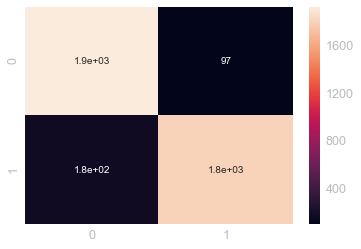

In [175]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True)

In [176]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.92      0.95      0.93      2019
         5.0       0.95      0.91      0.93      1981

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



In [177]:
models_result['Model'] += ['RandomForest']
models_result['Accuracy'] += [accuracy_score(y_test, y_test_pred)]
models_result['F1_score'] += [f1_score(y_test, y_test_pred)]

In [178]:
pd.DataFrame(models_result)

,Model,Accuracy,F1_score
0,MultinomialNB,0.92975,0.932109
1,RandomForest,0.93200,0.933916


RandomForest оказался немного более точным на тестовой выборке.